# Homework 4
 ***Egon Ferri, Flaminia Matteucci, Masha Hadikanloo***


![alt text](https://na.rdcpix.com/625946635/a545dc497c1d4e1385851ca5e12f5a14w-c0xd-w685_h860_q80.jpg)



In [84]:
import pandas as pd
from tqdm import tqdm
import time
import pickle
import json

import math
import numpy as np

import re
import requests
from bs4 import BeautifulSoup


from nltk.tokenize import sent_tokenize, word_tokenize, PunktSentenceTokenizer
from nltk.corpus import stopwords
import string
import nltk
from nltk.stem.snowball import SnowballStemmer

from datetime import datetime

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## 1) Does basic house information reflect house's description?

In this assignment we will perform a clustering analysis of house announcements in Rome from:

![alt text](http://www.cavourimmobiliare.com/wp-content/uploads/2018/04/immobiliareit_logo.jpg)

### Scraping
The first thing that we have to do is to create our dataset. As said, we catch informations from [immobiliare.it](https://www.immobiliare.it). In particular, we retrieve announcements starting from this [link](https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=1).


#### 1) Information
The first matrix will have this format: <img src="https://latex.codecogs.com/gif.latex?$m_{ij}&space;=&space;value$" title="$m_{ij} = value$" /> where <img src="https://latex.codecogs.com/gif.latex?$i&space;\in&space;\{announcement_1,&space;...,&space;announcement_n\}$" title="$i \in \{announcement_1, ..., announcement_n\}$" /> and <img src="https://latex.codecogs.com/gif.latex?$j&space;\in&space;\{price,&space;locali,&space;superficie,&space;bagni,&space;piano&space;\}$" title="$j \in \{price, locali, superficie, bagni, piano \}$" />
*n* is the number of the announcements.

It's possible that not all the announcements will have all the fields mentioned above, if it's the case we don't take them into account. 

We create an empty dataframe where we will store all the informations.

In [2]:
df= pd.DataFrame(index=['price', 'locali', 'superficie', 'bagni', 'piano'] )
df

""
price
locali
superficie
bagni
piano


We take informations of all the house in the first $700$ pages (every page contains $25$ announcements) and store them in our dataframe.

In [3]:
count=1
for i in range (1,700):
    # requests.get helps us to enter the page. 
    # Then BeatifulSoup gives us the xml format.
    content= requests.get("https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag="+str(i))
    soup = BeautifulSoup(content.text, "lxml")
    #we take separatly every announce and take all infos that we need.
    #by default infos are none, if we found them (using again soup and a regular expression) we set the new value.
    for j in soup.findAll("div", class_="listing-item_body"):
        annuncio='annuncio_'+str(count)
        locali= None
        superficie= None
        bagni = None
        piano = None
        try:
            price=j.find("li", class_="lif__item lif__pricing").contents[-1]
            price= int(price.replace('\n', ' ').replace('€', ' ').replace('.', '').replace(' ', ''))
        except:
            price=None
        resto=j.findAll("li", class_="lif__item")
        for k in range (len(resto)):
            if (len((re.findall(string=str(resto[k]), pattern=r'locali'))))==1:
                locali=resto[k].span.contents[0].replace('\xa0', ' ')
            if (len((re.findall(string=str(resto[k]), pattern=r'superficie'))))==1:
                superficie=int(resto[k].span.contents[0].replace('\xa0', ' ').replace('.', ''))
            if (len((re.findall(string=str(resto[k]), pattern=r'bagni'))))==1:
                bagni=resto[k].span.contents[0].replace('\xa0', ' ')
            if (len((re.findall(string=str(resto[k]), pattern=r'piano'))))==1:
                piano=resto[k].abbr.contents[0].replace('\xa0', ' ').replace('\n', ' ') 
        #at last we store them in our dataframe
        df[annuncio]=[price, locali, superficie, bagni, piano]
        count+=1

In [4]:
df

,annuncio_1,annuncio_2,annuncio_3,annuncio_4,annuncio_5,annuncio_6,annuncio_7,annuncio_8,annuncio_9,annuncio_10,...,annuncio_17463,annuncio_17464,annuncio_17465,annuncio_17466,annuncio_17467,annuncio_17468,annuncio_17469,annuncio_17470,annuncio_17471,annuncio_17472
price,192000,225000,1350000,135000,229000,249000,1399000,279000,339000,699000,...,None,269000,215000,246600,235000,254000,359000,529000,760000,220000
locali,1-5,2,4,2,5,2,5+,3,2,5+,...,5+,4,2,4,4,3,4,3,4,2
superficie,46,50,200,60,169,75,500,110,70,174,...,620,160,70,112,160,90,109,108,160,52
bagni,None,1,2,1,3+,1,3+,1,1,3,...,3+,1,1,2,2,1,2,2,2,1
piano,None,1,2,5,None,1,None,T,3,A,...,None,None,7,2,T,None,1,T,None,4


Now we drop all the columns that have `None` values:

In [7]:
df_1=df.dropna(axis='columns')

In [58]:
df_1=df_1.T

It's very useful to save our final dataframe in an external `pickle` file, so we can easly load it when in need.

In [59]:
df_1.to_pickle("df_1.pkl")

In [61]:
df_1= pd.read_pickle("df_1.pkl")
df_1.head()

,price,locali,superficie,bagni,piano
annuncio_2,225000,2,50,1,1
annuncio_3,1350000,4,200,2,2
annuncio_4,135000,2,60,1,5
annuncio_6,249000,2,75,1,1
annuncio_8,279000,3,110,1,T


In [63]:
df_1.describe()

,price,locali,superficie,bagni,piano
count,12942,12942,12942,12942,12942
unique,799,6,348,4,15
top,199000,3,90,1,1
freq,226,4777,634,6766,2905


We see that some columns contains non numerical values. We'll need to manage them before the clustering.

#### 2) Description
The second matrix will have this format: <img src="https://latex.codecogs.com/gif.latex?$m_{ij}&space;=&space;tfIdf_{ij}$" title="$m_{ij} = tfIdf_{ij}$" /> where <img src="https://latex.codecogs.com/gif.latex?$i&space;\in&space;\{announcement_1,&space;...,&space;announcement_n\}$" title="$i \in \{announcement_1, ..., announcement_n\}$" /> and <img src="https://latex.codecogs.com/gif.latex?$j&space;\in&space;\{word_1,&space;...,word_m\}$" title="$j \in \{word_1, ...,word_m\}$" />

*n* is the number of the announcements and *m* is the cardinality of the vocabulary. 


The first thing that we hve to do is to retrive the infos: in particular we want to get **full** description of every announce (so we have to go *inside* the url of every house).

In [3]:
count=1
for i in range (1,700):        
    # requests.get helps us to enter the page. 
    # Then BeatifulSoup gives us the xml format.
    try:
        content= requests.get("https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag="+str(i))
    except:
        time.sleep(100)
        content= requests.get("https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag="+str(i))      
    soup = BeautifulSoup(content.text, "lxml")
    for j in soup.findAll("div", class_="listing-item_body"):
        for link in j.find_all('a'):
            if link.get('href') is not None and (link.get('href').startswith('https')):
                url=(link.get('href'))
                content=requests.get(url)
                soup = BeautifulSoup(content.text, "lxml")
                desc=soup.find("div", class_="col-xs-12 description-text text-compressed")
                try:
                    descrizione=str(desc.contents[1])
                    #it's better to save the description in an external file, so we can restart from a checkpoint if something goes wrong
                    op = open(r'C:\Users\Egon\Desktop\Universita\ADM\HW4\doc\annuncio_' + str(count) + '.tsv', 'w', encoding="utf-8")
                    op.write(descrizione)
                    op.close()
                except: pass
        count+=1

Now we do some preprocessing: 
    
    creating functions:

In [2]:

# list of stopwords
stopWords = set(stopwords.words('italian'))
# the stemmer used
ps = SnowballStemmer("italian")

# list of punctuation used
string.punctuation = string.punctuation + '–“”’'


# preprocess takes a list of words as input and RETURNS a list of stemmed words without stopwords and punctuation
def preprocess(l):
    final = []
    for i in l:
        if not((ps.stem(i) in stopWords) or (ps.stem(i) in (string.punctuation) )):
            final.append(ps.stem(i))
    return (final)

    trying our functions:

In [33]:
op = open(r'C:\Users\Egon\Desktop\Universita\ADM\HW4\doc\annuncio_3.tsv', 'r', encoding="utf-8")
for line in op:
    ou = line.strip().split('\t')
    sentence = ou[0].replace('div', ' ').replace('/', ' ').replace('br', ' ')#.replace('\\r', ' ').replace('\\t', ' ')
    print(preprocess(word_tokenize(sentence)))
op.close()

[]
['fleming', 'strad', 'priv', 'via', 'alessandr', 'fleming', 'siam', 'liet', 'proporr', 'vend', 'via', 'esclus', 'quart', 'residenzial', 'fleming', 'immobil', 'rappresent', '200mq', 'oltre', 'spaz', 'estern', 'pertint', 'affacc', 'riserv', 'verd', 'panoram', 'vist', 'san', 'pietr', 'post', 'second', 'pian', 'alto', 'tre', "un'eleg", 'palazzin', 'cortin', 'perfett', 'stat', 'manutenzion', 'serviz', 'portiner', 'cas', 'recent', 'restaur', 'import', 'stud', 'architettur', 'present', 'rifin', 'material', 'preg', 'ogni', 'particol', 'parquet', 'ogni', 'ambient', 'marm', 'bagn', 'armad', 'soppalc', 'finitur', 'falegnamer', 'misur', 'climatizz', 'canalizz', 'infiss', 'tagl', 'termic', 'serrand', 'elettr', 'port', 'blind', 'impiant', 'allarm', 'sorvegl', 'intern', 'compost', 'ingress', 'guardarob', 'ostip', 'salon', 'dopp', 'lumin', 'vetr', 'access', 'terrazzin', 'ampi', 'cucin', 'abit', 'isol', 'central', 'balcon', 'zon', 'nott', 'compost', 'due', 'cam', 'matrimonial', 'camer', 'padronal', 

Now we have to create a vocabulary that contains all the words of our corpus (we store it in an external `json` file):

In [34]:
def vocabularization(vocabulary, final, index):
    for word in final:
        if not(word in vocabulary):
            vocabulary[word] = str(index)
            index = index + 1
    return(vocabulary, index)

In [68]:
vocabulary= {}
index = 0

for i in range(17472):
    try:
        op = open(r'C:\Users\Egon\Desktop\Universita\ADM\HW4\doc\annuncio_' + str(i) + '.tsv', 'r', encoding="utf-8")
        for line in op:
            ou = line.strip().split('\t')
            sentence = ou[0].replace('div', ' ').replace('/', ' ').replace('br', ' ')        
            #preprocessing data deleting stop words, punctuations, ecc. 
            final = preprocess(word_tokenize(sentence))
            # IF  word not in vocabulary -> add the word
            vocabulary, index = vocabularization(vocabulary, final, index)            
        op.close()
    except: pass
op = open(r'C:\Users\Egon\Desktop\Universita\ADM\HW4\vocabulary.txt', 'w', encoding="utf-8")
op.write(json.dumps(vocabulary))
op.close()

In [2]:
# opening vocabulary.txt
op = open(r'C:\Users\Egon\Desktop\Universita\ADM\HW4\vocabulary.txt', 'r', encoding="utf-8")
vocabulary = json.loads(op.read())

Now we create an inverted index that associate words and announcement that contains that word:
It will be a dictionary of this format:

```
{
term_id_1:[announcement_1, announcement_2, announcement_4],
term_id_2:[announcement_1, announcement_3, announcement_5, announcement_6],
...}
```



We also want to store it in a separate file, `inverted_index_0.txt` , and load it in memory with json when needed.

In [129]:
# from the vocabulary, the inverted index is created
inverted_index_0 = {}

for file in range(17472):
    try:
        op = open(r'C:\Users\Egon\Desktop\Universita\ADM\HW4\doc\annuncio_' + str(file) + '.tsv', 'r', encoding="utf-8")
        for line in op:
            ou = line.strip().split('\t')
            sentence = ou[0].replace('div', ' ').replace('/', ' ').replace('br', ' ')        
            #preprocessing data deleting stop words, punctuations, ecc. 
            final = preprocess(word_tokenize(sentence))
            for word in final:
                index = vocabulary[word]
                if not (index in inverted_index_0):
                    inverted_index_0[index] = ['annuncio_' + str(file)]
                elif not('annuncio_' + str(file) in inverted_index_0[index]):
                    inverted_index_0[index] = inverted_index_0[index] + ['annuncio_' + str(file)]
        op.close()
    except: pass

op = open(r'C:\Users\Egon\Desktop\Universita\ADM\HW4\inverted_index_0.txt', 'w', encoding="utf-8")
op.write(json.dumps(inverted_index_0))
op.close()

In [3]:
op = open(r'C:\Users\Egon\Desktop\Universita\ADM\HW4\inverted_index_0.txt', 'r', encoding="utf-8")
inverted_index_0 = json.loads(op.read())


Now we can create our `inverted index` that stores in a tuple the `tf-idf` associated with word and announcement.

With `TF` we mean Term Frequency, or times that a certain term occurred in a query or in a doc. We also want to normalize the document based on its size and we can do it dividing the term frequency by the total number of terms. 

With `IDF` we mean Inverse Document Frequency. Inverse Document Frequencies help us to _weigh down_ the effects of too frequently occurring term(and _weigh up_ less frequent terms). 

We can calculate it using logarithms: $\log (\frac{n}{m})$ with $n= Total\ number\ of\ docs\ $ and $m= Number\ Of\ Documents\ with\ term\ game\ in\ it$.

In [72]:
# from the vocabulary the inverted index is created. In this case the index are mapped to a tuple (doc, tf-idf).

inverted_index = {}
for file in range(17472):
    try:        
        op = open(r'C:\Users\Egon\Desktop\Universita\ADM\HW4\doc\annuncio_' + str(file) + '.tsv', 'r', encoding="utf-8")
        desc=[]
        for line in op:
            ou = line.strip().split('\t')
            sentence = ou[0].replace('div', ' ').replace('/', ' ').replace('br', ' ')        
            #preprocessing data deleting stop words, punctuations, ecc. 
            final = preprocess(word_tokenize(sentence))
            #creating inverted index with tf-idf values
            desc.extend(final)
        for word in desc:
            index = vocabulary[word]               
            tf = desc.count(word) / len(desc)               
            idf = math.log( 17420 / len(inverted_index_0[vocabulary[word]]))
            tf_idf = tf*idf
            if not (index in inverted_index):
                inverted_index[index] = [('annuncio_' + str(file), tf_idf )]
            elif not(('annuncio_' + str(file), tf_idf)  in inverted_index[index]):
                inverted_index[index] = inverted_index[index] + [('annuncio_' + str(file), tf_idf)]      
        op.close()
    except:pass
op = open(r'C:\Users\Egon\Desktop\Universita\ADM\HW4\inverted_index.txt', 'w', encoding="utf-8")
op.write(json.dumps(inverted_index))
op.close()

In [4]:
op = open(r'C:\Users\Egon\Desktop\Universita\ADM\HW4\inverted_index.txt', 'r', encoding="utf-8")
inverted_index = json.loads(op.read())


Now we can finally build our beloved data frame.
At first we initialzie a new df setting as rows the announcements.

In [3]:
righe=[]
for i in range (17473):
    righe.append('annuncio_'+str(i))
df_2=pd.DataFrame(0,columns=[], index=righe)
df_2.head()

""
annuncio_0
annuncio_1
annuncio_2
annuncio_3
annuncio_4


Now we take every word of our dictionary separatly and we create a columns with it's `tf-idf`.

In [4]:
for word in range(37999):
    #for every word, at first we initialize an array full of zeros, then we substitute values with tf-idf
    array=np.zeros(17473)
    for ann in inverted_index[str(word)]:
        annuncio=(ann[0])
        tf_idf=(ann[1])
        array[int(annuncio.replace('annuncio_', ''))]=tf_idf
        df_2[word]=array
df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,37989,37990,37991,37992,37993,37994,37995,37996,37997,37998
annuncio_0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
annuncio_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
annuncio_2,0.068564,0.022727,0.029379,0.025256,0.023229,0.055761,0.032966,0.004129,0.011766,0.018419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
annuncio_3,0.000000,0.000000,0.000000,0.000000,0.011615,0.000000,0.000000,0.004129,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
annuncio_4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we want to uniform the corpus of the announcement, since we dropped a lot of rows in the first `dataframe`. 

We filter the second `dataframe` taking only the announcement that we had in the first.

In [5]:
coldf1=df_1.T.columns
coldf1

Index(['annuncio_2', 'annuncio_3', 'annuncio_4', 'annuncio_6', 'annuncio_8',
       'annuncio_9', 'annuncio_10', 'annuncio_12', 'annuncio_13',
       'annuncio_15',
       ...
       'annuncio_17457', 'annuncio_17458', 'annuncio_17459', 'annuncio_17461',
       'annuncio_17465', 'annuncio_17466', 'annuncio_17467', 'annuncio_17469',
       'annuncio_17470', 'annuncio_17472'],
      dtype='object', length=12942)

In [6]:
df_2=df_2.T.filter(coldf1).T
df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,37989,37990,37991,37992,37993,37994,37995,37996,37997,37998
annuncio_2,0.068564,0.022727,0.029379,0.025256,0.023229,0.055761,0.032966,0.004129,0.011766,0.018419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
annuncio_3,0.000000,0.000000,0.000000,0.000000,0.011615,0.000000,0.000000,0.004129,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
annuncio_4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
annuncio_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
annuncio_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003804,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_2.to_pickle("df_2.pkl")



### Clustering
This step consists in clustering the house announcements using K-means++. In order to do that we use [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) Python library. We also want to choose the optimal number of clusters using the [Elbow-Method](https://en.wikipedia.org/wiki/Elbow_method_(clustering).


The first thing that we have to do is to reload our matrices.

In [2]:
df_1= pd.read_pickle("df_1.pkl")

In [40]:
df_1.head()

,price,locali,superficie,bagni,piano
annuncio_2,225000,2,50,1,1
annuncio_3,1350000,4,200,2,2
annuncio_4,135000,2,60,1,5
annuncio_6,249000,2,75,1,1
annuncio_8,279000,3,110,1,T


In [3]:
df_2= pd.read_pickle("df_2.pkl")
df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,37989,37990,37991,37992,37993,37994,37995,37996,37997,37998
annuncio_2,0.068564,0.022727,0.029379,0.025256,0.023229,0.055761,0.032966,0.004129,0.011766,0.018419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
annuncio_3,0.000000,0.000000,0.000000,0.000000,0.011615,0.000000,0.000000,0.004129,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
annuncio_4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
annuncio_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
annuncio_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003804,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We see that our first matrix has some categorical values, so we have to trasform them in numerical.

In [43]:
df_1['locali']=pd.factorize(df_1['locali'], sort=True)[0]
df_1['bagni']=pd.factorize(df_1['bagni'], sort=True)[0]
df_1['piano']=pd.factorize(df_1['piano'], sort=True)[0]

In [44]:
df_1.head()

,price,locali,superficie,bagni,piano
annuncio_2,225000,1,50,0,0
annuncio_3,1350000,3,200,1,3
annuncio_4,135000,1,60,0,6
annuncio_6,249000,1,75,0,0
annuncio_8,279000,2,110,0,14


In [45]:
df_1.to_pickle("df_1.pkl")

In [3]:
df_1= pd.read_pickle("df_1.pkl")
df_1.head()

,price,locali,superficie,bagni,piano
annuncio_2,225000,1,50,0,0
annuncio_3,1350000,3,200,1,3
annuncio_4,135000,1,60,0,6
annuncio_6,249000,1,75,0,0
annuncio_8,279000,2,110,0,14


The **Elbow method** is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset.

This method looks at  `inertia` explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. More precisely, if one plots the `inertia` against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion". This "elbow" cannot always be unambiguously identified(as we will see).

   `inertia` : Sum of squared distances of samples to their closest cluster center (Within-Cluster-Sum-of-Squares abbreviated  in WCSS)

In [4]:
wcss=[]
for i in range(1, 10):
    kmeans_df=KMeans(n_clusters= i, init= 'k-means++').fit(df_1)
    wcss.append(kmeans_df.inertia_)
    

In [78]:
wcss

[1978504008452443.5,
 880347837318401.0,
 491377882171838.0,
 304136105709781.4,
 210252975165927.94,
 146409099519500.66,
 106071910175127.92,
 79665617146300.48,
 64701444637437.5]

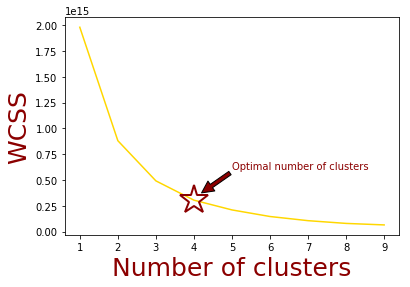

In [28]:
x = range(1, 10 )
y = wcss
fig = plt.figure()
plt.plot(x,y, color= 'gold')
plt.plot(x[3], y[3], '*', ms=30, mec='darkred', mfc='none', mew=2,)
plt.annotate('Optimal number of clusters',color="darkred",
             xy=(4.2,15*25000000000000), xytext=(5,15*40000000000000),
             arrowprops = dict(facecolor='darkred', shrink=2))
plt.xlabel("Number of clusters", fontsize= 25, color='darkred')
plt.ylabel("WCSS", fontsize= 25, color='darkred')
plt.show()

The optimal number of clusters seems to be  4.

In [32]:
kmeans_df_=KMeans(n_clusters= 4, init= 'k-means++').fit(df_1)
kmeans_df_.labels_

array([1, 3, 1, ..., 1, 0, 1])

In [33]:
lab1=kmeans_df_.labels_

We write an inverted dictionary that gives us the list of the announcment contained by each cluster:

In [34]:
lab1=kmeans_df_.labels_
Cluster1={}
count=0
for i in lab1:
    if not (i in Cluster1):
        Cluster1[i] = [count]
    else:
        Cluster1[i] += [count]
    count+=1   

We try to repeat the same analisys for the second matrix:

In [23]:
wcss2=[]
for i in tqdm([1, 2, 5, 10, 15, 20]):
    kmeans_df2=KMeans(n_clusters= i, init= 'k-means++',n_init=5,max_iter=50 ).fit(df_2)
    wcss2.append(kmeans_df2.inertia_)
with open("wcss2.txt", "wb") as fp:   
    pickle.dump(wcss2, fp)


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [36:57<00:00, 429.83s/it]


In [36]:
with open("wcss2.txt", "rb") as fp:   # Unpickling
    wcss2= pickle.load(fp)
wcss2

[1913.3102967551417,
 1898.9652873115808,
 1887.2734647656785,
 1855.0751723969875,
 1842.9201315562748,
 1821.1572833553864]

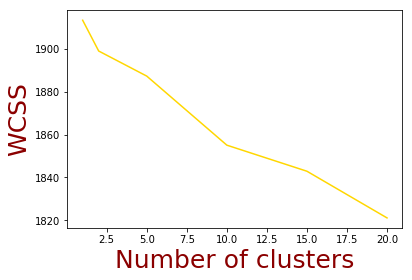

In [39]:

x =[1, 2, 5, 10, 15, 20]
y = wcss2
fig = plt.figure()
plt.plot(x,y, color= 'gold')

plt.xlabel("Number of clusters", fontsize= 25, color='darkred')
plt.ylabel("WCSS", fontsize= 25, color='darkred')
plt.show()

As we see, the WCSS in this case doesn't seems to help us; for any number of cluster that we take in consideration (values between 1 and 20) we have a very high wcss. Increasing the number of cluster does not help.
This totally make sense: we have a veeeery sparse matrix that has a lot of features but it's full of zero values; we can expect that the inertia will drop for a very high number of clusters (maybe really close to the number of features).
Unfortunally we can't verify that; trying to compute `Kmeans++` with thousands of cluster would be really computationally expensive.
In fact, the complexity of the algo is something like the order of: $$ \mathcal{O} (n \cdot m\ \cdot k\ \cdot i)$$ (Where n and m are the number of rows and columns, k is the number of clusters and i the number of iterations).

The complexity of the algo grows exponentially with $k$ ! We empirically verified that already for $k=20$ we're stressing the CPU, so it appears undoable.

Morover, it would be nonsense. Even if the elbow method would suggest it, make thousands of small clusters wouldn't help our analysis, so we decide to take arbitrarly $k=4$ to procede with the work
.


In [40]:
kmeans_df2=KMeans(n_clusters= 4, init= 'k-means++',n_init=10, max_iter=300).fit(df_2)

In [41]:
kmeans_df2.labels_

array([1, 1, 3, ..., 1, 3, 1])

In [42]:
lab2=kmeans_df2.labels_
Cluster2={}
count=0
for i in lab2:
    if not (i in Cluster2):
        Cluster2[i] = [count]
    else:
        Cluster2[i] += [count]
    count+=1

### Comparison among cluster
We expect that both datasets will lead to similar clusters. Is this true?
#### Find similar clusters
To check this, we use the Jaccard-Similarity to measure the similarity betweeen the two outputs (information clusters vs description clusters). 

The Jaccard similarity coefficient is a statistic used for comparing the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

$$ J(A,B) = {{|A \cap B|}\over{|A \cup B|}} = {{|A \cap B|}\over{|A| + |B| - |A \cap B|}}. $$


In [43]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [65]:
dfjaccard=pd.DataFrame(columns=range(0,4), index=range(0,4))
for clus in sorted(Cluster1):
    for clus2 in sorted(Cluster2):
        x=Cluster1[clus]
        y=Cluster2[clus2]
        dfjaccard[clus][clus2]=round(jaccard_similarity(x,y), 2)
dfjaccard


,0,1,2,3
0,0,0,0,0
1,0.22,0.61,0.01,0.05
2,0.01,0.01,0.01,0.01
3,0.1,0.17,0.01,0.04


We see immediatly that we have some similarities (not a lot to be honest...) the most similar couple of clusters are: $(1;1), (0;1), (1;3)$.

#### Word cloud of house descriptions
With this last output we create a [wordcloud](https://www.datacamp.com/community/tutorials/wordcloud-python) for each couple of clusters. The words that will be represented are those extracted from the description of the houses that are in the intersection of the relative couple.

In [66]:
wordcloud1= set(Cluster1[1]).intersection(set(Cluster2[1]))
wordcloud2= set(Cluster1[0]).intersection(set(Cluster2[1]))
wordcloud3= set(Cluster1[1]).intersection(set(Cluster2[3]))


We have to update the set of stopwords: the default lenguage is english and we're working with italian language.

In [85]:
filtered_cloud = [word for word in stopwords.words('italian')]
stopwords = set(STOPWORDS)
stopwords.update(filtered_cloud)


Now we can build our wordclouds:

In [79]:
#creating the text with all the words of the description of the announcement in the intersection
text1=" "
for ann in wordcloud1:
    annuncio=df_2.index[ann]
    try:
        op = open(r'C:\Users\Egon\Desktop\Universita\ADM\HW4\doc\\' + str(annuncio) + '.tsv', 'r', encoding="utf-8")
        for line in op:
            ou = line.strip().split('\t')
            sentence = ou[0].replace('div', ' ').replace('/', ' ').replace('br', ' ').replace('<', ' ').replace('>', ' ').replace('cucina', ' ').replace('abitabile', ' ').replace('proponiamo', ' ').replace('vendita', ' ')
            text1 +=sentence
        op.close()
    except: pass

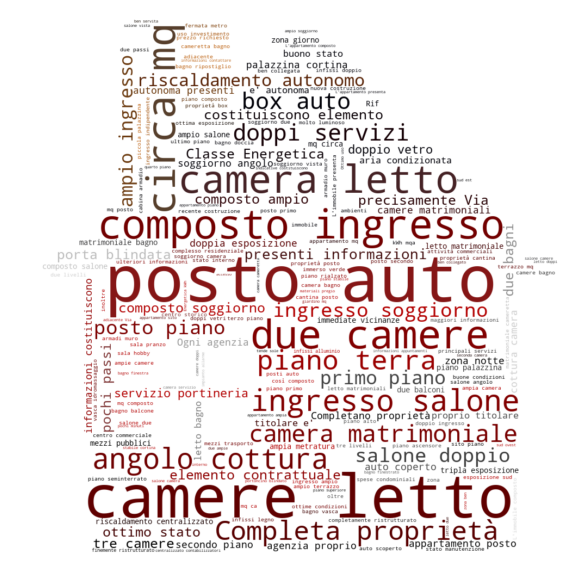

In [111]:
#uploading the image that we want to use as a mask
mask = np.array(Image.open("casa1.png"))
#generating the wordcloud
wordcloud = WordCloud(stopwords=stopwords,background_color='white', mask=mask).generate(text1)
#setting the colors
image_colors = ImageColorGenerator(mask)
#plotting
plt.figure(figsize=[10,10])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

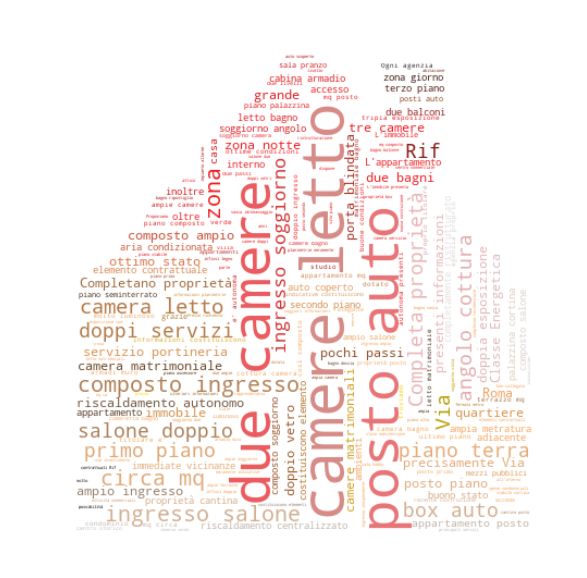

In [112]:
text2=" "
for ann in wordcloud2:
    annuncio=df_2.index[ann]
    try:
        op = open(r'C:\Users\Egon\Desktop\Universita\ADM\HW4\doc\\' + str(annuncio) + '.tsv', 'r', encoding="utf-8")
        for line in op:
            ou = line.strip().split('\t')
            sentence = ou[0].replace('div', ' ').replace('/', ' ').replace('br', ' ').replace('<', ' ').replace('>', ' ').replace('hr', ' ').replace('cucina', ' ').replace('abitabile', ' ').replace('proponiamo', ' ').replace('vendita', ' ')
            text2 +=sentence
        op.close()
    except: pass
mask = np.array(Image.open("casa2.png"))
wordcloud = WordCloud(stopwords=stopwords,background_color='white', mask=mask).generate(text2)
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

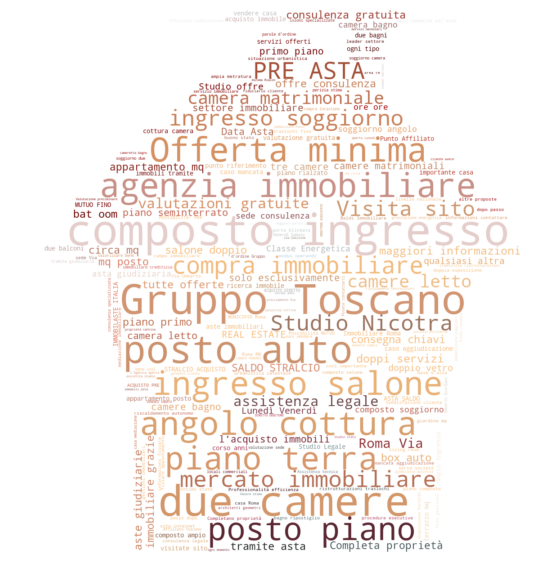

In [118]:
text3=" "
for ann in wordcloud3:
    annuncio=df_2.index[ann]
    try:
        op = open(r'C:\Users\Egon\Desktop\Universita\ADM\HW4\doc\\' + str(annuncio) + '.tsv', 'r', encoding="utf-8")
        for line in op:
            ou = line.strip().split('\t')
            sentence = ou[0].replace('div', ' ').replace('/', ' ').replace('br', ' ').replace('<', ' ').replace('>', ' ').replace('hr', ' ').replace('cucina', ' ').replace('abitabile', ' ').replace('proponiamo', ' ').replace('vendita', ' ')
            text3 +=sentence
        op.close()
    except: pass
mask = np.array(Image.open("casa3.jpg"))
wordcloud = WordCloud(stopwords=stopwords,background_color='white', mask=mask).generate(text3)
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

### Bonus Clustering
* We implement the K-means algorithm  from scratch creating the class KMeans. 

In [119]:
class KMeans:
    def updateClusters(self):
        #assaign each observation to the closest cluster 
        clus = {i: [] for i in range(self.k)}
        for i in range(self.m): #msonolerighe
            d= np.sum((self.X[i]- self.centroids)**2, axis= 1)
            idx= np.argmin(d)
            clus[idx] += [i]
        self.clustering= clus
        
    def updateCentroids(self):
        for i in range(self.k):
            self.centroids[i]=np.mean(self.X[self.clustering[i]], axis= 0)
            
    def __init__(self, X, k, max_itr=1000):
        #1. select k points at random from X
        #2. while centroids not stable: reassign and recompute
        self.X, self.k= X, k
        self.m, self.d = X.shape #m righe, d colonne
        self.centroids= X[np.random.choice(self.m, k, replace= False)]
        self.iter= 0
        while True:
            self.updateClusters()
            oldCentroids = self.centroids.copy()
            self.updateCentroids()
            self.iter +=1
            if (self.centroids == oldCentroids).all() or self.iter >=max_itr:
                break

In [129]:
km=KMeans(df_1.values,4)

Now we check if it worked:

In [131]:
dfjaccard2=pd.DataFrame(columns=range(0,4), index=range(0,4))
for clus in sorted(Cluster1):
    for clus2 in sorted(km.clustering):
        x=Cluster1[clus]
        y=km.clustering[clus2]
        dfjaccard2[clus][clus2]=round(jaccard_similarity(x,y), 2)
dfjaccard2

,0,1,2,3
0,0.91,0.02,0,0
1,0,0.98,0,0
2,0,0,0.81,0.03
3,0.02,0,0,0.86


We see that we have a very strong similarity! Our kmeans is working, and it's working very well.

![alt text](https://i.pinimg.com/originals/fb/e4/a1/fbe4a12a0b9209267391408e32b5c5ae.jpg)